# Chapter 16: Contextual Word Embeddings with Transformers

To run this notebook on Google Colab, you will need to install the following libraries: transformers, evaluate, sentence-transformers, and datasets.

In Google Colab, you can run the following command to install them:

In [ ]:
!pip install transformers evaluate portalocker sentence-transformers datasets

Moreover, we'll be using a set of classes developed with the specific purpose of illustrating a few concepts we'll discuss in this chapter. We're making them available in a Python file for your convenience. You can download it from the following link:

https://raw.githubusercontent.com/lftraining/LFD273-code/main/educational_transformer.py

In Google Colab, you can run the following command to download the file:

In [ ]:
!wget https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/educational_transformer.py

--2024-09-09 17:15:47--  https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/educational_transformer.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5593 (5.5K) [text/plain]
Saving to: ‘educational_transformer.py’

educational_transfo 100%[===================>]   5.46K  --.-KB/s    in 0.002s  

2024-09-09 17:15:47 (3.48 MB/s) - ‘educational_transformer.py’ saved [5593/5593]



Once the file is downloaded, you only need to import the required helper function:

In [ ]:
from educational_transformer import PositionalEncoding, EncoderLayer, EncoderTransf

## 16.2 Learning Objectives

By the end of this chapter, you should be able to:
- understand the principles behind the Transformer architecture and the attention mechanism
- understand the role of the special classifier token and use it to classify text
- train a small Transformer model from scratch
- obtain sentence embeddings using the SentenceTransformers package

## 16.3 Attention Is All You Need

Not every token is born equal: some tokens are more relevant than others depending on the task we're performing. Take, for example, translating a sentence from English to French, or the other way around. There's roughly a one-to-one correspondence between the words in the original and the translated sentence. But, that's not always the case, especially if one of the languages (such as French) has grammatical genders and the other doesn't (such as English).

Here is a simple example: translating "The European economic zone" to French. "Zone", in French, is a feminine noun, and the adjective (European) must agree with the noun, making the correct translation "euroṕéenne" (as opposed to "européen" if it were a masculine noun). This means that, in order to translate, "European" to "européenne", the translator needs to pay attention to the noun it refers to ("zone", in this case) so it can adjust it to the right gender.

Let's pretend for a little while that we're the translator, and someone asks us to report how much each word in the original sentence contributes to the translated sentence. In other words, they're asking us to report what we were paying attention to in the original sentence as we translated it into French. Roughly speaking, you could come up with a matrix like the one below:

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch14/translation_att.png)

Paying attention to words during translation

In every row, the values add up to one, the total attention "budget", if you will, available to translate a given word. "La", French's feminine version of "the" is mostly driven by "the" itself, but also a little bit by the noun it refers to, "zone". The word "zone", regardless of its gender in French, is translated directly without the need to know anything else about the original sentence, so it receives the full attention of the translator. Does it make sense? Hopefully it does, because this idea is the bedrock upon which the whole field of Natural Language Processing is currently built.

The idea was championed in the now-famous "[Attention Is All You Need](https://arxiv.org/abs/1706.03762)" paper from 2017. In the past, sequences were mostly handled by recurrent neural networks, but these models were only capable of processing the inputs (tokens) of a sequence one-by-one, in the very order they showed up. This made it extremely hard for the models to learn the relationship between different parts of the input, as it is often required by tasks such as translation (as shown above).

If the translator may choose which words they should pay attention to in order to translate a sentence, why couldn't a model do just that?

Even though the idea, in a nutshell, is of such elegance and simplicity, its implementation is somewhat tricky, so we're not delving into its details here. You should know, however, that models usually implement multi-headed attention mechanisms, meaning that the models learn multiple (and possibly different) ways of paying attention to the tokens in order to accomplish the tasks they are being trained for. Moreover, due to some particularities of the attention mechanism, they also implement what's called "position encoding" or "position embedding" to include information regarding the position of a given token in the sequence (first, second, etc.).

## 16.4 Transformer

For all its might, the Transformer architecture is surprisingly simple in its essence. Each Transformer "layer" is basically a combination of a multi-headed attention mechanism and a traditional feed-forward network (that is, some linear layers and activation functions) with a few "sprinkles" added to the mix (e.g. dropout and normalization layers).

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch14/stacked_layers.png)

Simplified scheme of Transformer's architecture,by [Daniel Voigt Godoy](https://github.com/dvgodoy/dl-visuals) is licensed under CC-BY-4.0

Then, the Transformer itself is a big stack of the Transformer "layers" we've just described. That's it. The more "layers" you stack, and the more attention heads they have, the more powerful the model gets.

The diagram below depicts the typical Transformer architecture, all details included:

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch14/full_transformer.png)

Transformer's architecture in detail,by Daniel Voigt Godoy is licensed under CC-BY-4.0

***

The left side of the diagram depicts the encoder part of the Transformer, the part that powers models such as BERT (thus encoder-based models) and that are commonly used for embedding sentences, and to perform tasks such as text classification. We're focusing on the encoder part first, and we'll discuss the decoder part later in this course.

**ASIDE: BERT**

BERT, which stands for Bidirectional Encoder Representations from Transformers, is a model based on a Transformer encoder introduced in 2019. The original BERT model was trained on two huge corpora: [BookCorpus](https://yknzhu.wixsite.com/mbweb) (composed of 800M words in 11,038 unpublished books) and [English Wikipedia](https://en.wikipedia.org/wiki/English_Wikipedia) (2.5B words). It has twelve "layers" (the original Transformer had only six), twelve attention heads, and 768 hidden dimensions, totaling 110 million parameters.

There are many different versions of BERT for all tastes and budgets, and you can find them in Google Research’s [BERT repository](https://github.com/google-research/bert). For a general overview of BERT, please check Jay Alammar’s excellent posts on the topic: ["The Illustrated BERT, ELMo, and co. (How NLP Cracked Transfer Learning)"](https://jalammar.github.io/illustrated-bert/) and ["A Visual Guide to Using BERT for the First Time."](https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/)
***

## 16.5 An Encoder-Based Model for Classification

An Encoder-Based Model for Classification: Overview
Let's build a Transformer Encoder of a single layer with two attention heads and use it to classify sentences from the AG News Dataset once again. We'll go over a quick walkthrough of what happens to a sentence, from being tokenized as an input, all the way to its corresponding four logits used to classify it. We will be focusing on the transformations along the way without paying too much detail to the inner workings and architecture of the Transformer itself.

It is important to highlight that the model we're building here is somewhat of a "hybrid" model since we're using pretrained GloVe word embeddings instead of learning the embeddings along the way. However, there's one embedding our model we'll learn, and that's a very special one: the embedding corresponding to the classifier special token we've already discussed. We'll get to that shortly.

### 16.5.1 AG News Dataset

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/data_step1.png)

Before proceeding, let's download the AG News dataset once again, and build a "raw" datapipe that parses the CSV files and cleans up the descriptions, just like we did before. Let's quickly retrace our steps here to prepare the dataset.

You can download the files from the following links:

https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv

https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv

https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/classes.txt

Alternatively, you can download all files as a single compressed file instead:

https://raw.githubusercontent.com/lftraining/LFD273-code/main/data/AGNews/agnews.zip

If you're running Google Colab, you can download the files using the commands below:

In [ ]:
!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv
!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv
!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/classes.txt

--2024-09-09 17:16:01--  https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29470338 (28M) [text/plain]
Saving to: ‘train.csv.1’

train.csv.1         100%[===================>]  28.10M  10.6MB/s    in 2.6s    

2024-09-09 17:16:03 (10.6 MB/s) - ‘train.csv.1’ saved [29470338/29470338]

--2024-09-09 17:16:03--  https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/data_step2.png)

Next, let's do some data cleaning, getting rid of a few HTML tags, replacing some special characters, etc. Here is a non-exhaustive list of characters and tags for replacement:

In [ ]:
import numpy as np

chr_codes = np.array([
     36,   151,    38,  8220,   147,   148,   146,   225,   133,    39,  8221,  8212,   232,   149,   145,   233,
  64257,  8217,   163,   160,    91,    93,  8211,  8482,   234,    37,  8364,   153,   195,   169
])
chr_subst = {f' #{c};':chr(c) for c in chr_codes}
chr_subst.update({' amp;': '&', ' quot;': "'", ' hellip;': '...', ' nbsp;': ' ', '&lt;': '', '&gt;': '',
                  '&lt;em&gt;': '', '&lt;/em&gt;': '', '&lt;strong&gt;': '', '&lt;/strong&gt;': ''})

And here are a couple of helper functions we used to perform the cleanup:

In [ ]:
def replace_chars(sent):
    to_replace = [c for c in list(chr_subst.keys()) if c in sent]
    for c in to_replace:
        sent = sent.replace(c, chr_subst[c])
    return sent

def preproc_description(desc):
    desc = desc.replace('\\', ' ').strip()
    return replace_chars(desc)

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/data_step4.png)

After loading the CSV files using load_dataset() and building a DatasetDict out of them, we used the functions above to transform our datasets, cleaning up the text and converting the label into a 0-based numeric value:

In [ ]:
from datasets import load_dataset, Split, DatasetDict

colnames = ['topic', 'title', 'news']

train_ds = load_dataset("csv", data_files='train.csv', sep=',', split=Split.ALL, column_names=colnames)
test_ds = load_dataset("csv", data_files='test.csv', sep=',', split=Split.ALL, column_names=colnames)

datasets = DatasetDict({'train': train_ds, 'test': test_ds})
datasets = datasets.map(lambda row: {'topic': row['topic']-1, 'news': preproc_description(row['news'])})
datasets = datasets.select_columns(['topic', 'news'])

Found cached dataset csv (/home/dvgodoy/.cache/huggingface/datasets/csv/default-e74aa9f4afc75bd6/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)
Found cached dataset csv (/home/dvgodoy/.cache/huggingface/datasets/csv/default-b95e4b26323eb18c/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

Finally, we created their corresponding data loaders:

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/data_step5.png)

In [ ]:
from torch.utils.data import DataLoader

dataloaders = {}
dataloaders['train'] = DataLoader(dataset=datasets['train'], batch_size=32, shuffle=True)
dataloaders['test'] = DataLoader(dataset=datasets['test'], batch_size=32)

Now, we're ready to take the next step.

### 16.5.2 Tokenizing and Padding

First, let's start with the basics: a tokenizer, GloVe embeddings and their corresponding dimensions (50, which will be used as the number of dimensions of the model as well), the maximum length (in number of tokens, above which it will be truncated) of the inputs that our model will take, and the number of outputs (four, one logit for each class).

In [ ]:
from gensim import downloader
from gensim.utils import simple_preprocess

vector = downloader.load('glove-wiki-gigaword-50')

tokenizer = simple_preprocess
d_model = vector.vector_size
max_length = 100
n_outputs = 4

key_to_index = vector.key_to_index
pad_token_id = len(key_to_index)
unk_token_id = pad_token_id + 1

We'll be using the encode_batch() function from Lab 6 to convert tokens into token IDs, reproduced below:

In [ ]:
def encode_str(key_to_index, tokens, unk_token_id):
    token_ids = [key_to_index.get(token, unk_token_id) for token in tokens]
    return token_ids

def encode_batch(key_to_index, batch, max_len=None, padding=False, pad_token_id=-1, unk_token_id=-1):
    # Truncate every sentence to max_len
    # write your code here
    if isinstance(max_len, int):
        truncated = [s[:max_len] for s in batch]
    else:
        truncated = batch[:]

    # Check the actual maximum length of the (truncated) inputs
    # write your code here
    current_max = max([len(s) for s in truncated])

    batch_ids = []
    for tokens in truncated:
        token_ids = encode_str(key_to_index, tokens, unk_token_id)
        if padding:
            # Appends as many padding tokens as necessary to make every
            # sentence as long as the actual maximum length
            # write your code here
            token_ids.extend([pad_token_id] * (current_max - len(token_ids)))
        batch_ids.append(token_ids)
    return batch_ids

Let's retrieve a mini-batch from our training set, tokenize its sentences, and convert the tokens into token IDs using the the encode_batch() helper function. Notice that we're "saving" one space in the maximum length to account for the classifier token we'll be prepending to each sequence of tokens.

The padded sentence will likely be a different one thanks to the shuffling of the training set. If you don't see any padding tokens, chances are the sentence you got is longer than 100 tokens.

In [ ]:
batch = next(iter(dataloaders['train']))

labels, sentences = batch['topic'], batch['news']

tokenized_X = [tokenizer(d) for d in sentences]

padded_X = encode_batch(key_to_index,
                        tokenized_X,
                        max_len=max_length-1,
                        padding=True,
                        pad_token_id=pad_token_id,
                        unk_token_id=unk_token_id)
print(padded_X[:3])

[[516, 10851, 85, 2020, 384, 6099, 3146, 6713, 43, 33, 26, 1574, 98, 555, 214, 1365, 10, 5663, 1435, 6, 614, 1518, 6, 0, 147, 1084, 344, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000], [5438, 5, 98222, 4650, 28192, 4869, 10603, 522, 128, 394, 4, 5677, 1790, 5, 8169, 4869, 10603, 46323, 2817, 0, 337, 457, 373, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000],

There are several padding tokens appended to the sentence, but we'd like to ignore these tokens during classification, since they are meaningless. Therefore, we need a padding mask to determine which tokens come from the original sentence, and which ones are there for padding only.

Masks are a big part of Transformers: there are padding masks, target masks, source masks, you name it. Their purpose is always the same, to distinguish between the tokens we want the model to use, and the tokens we want the model to ignore. Keep in mind, though, that the convention used for masking may be the opposite you might expect: some implementations use it as "tokens you ignore" while others use it as "tokens you keep".

In PyTorch, masks are implemented as "tokens you ignore", so every padding token should correspond to a True value in the mask, meaning it should be ignored by the model.

In [ ]:
import torch

# If a BoolTensor is provided, positions with True is not allowed to attend while False values will be unchanged.
# https://pytorch.org/tutorials/beginner/translation_transformer.html
# src_padding_mask = (src == PAD_IDX).transpose(0, 1)

pad_mask = torch.as_tensor(padded_X) == pad_token_id
pad_mask.shape, pad_mask[0]

(torch.Size([32, 71]),
 tensor([False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True]))

As you can see, there are as many True values in the padding mask as there are padding tokens in the sentence.

Since your sentence is likely different from the one shown here, the number of positions marked as True will also differ - they must correspond to the padding tokens in the sentence you got. Moreover, the values for the embeddings you'll get in the next few sections are also going to be different because they must correspond to the sentence you got as well.

### 16.5.3 Word Embeddings

This particular step should already be familiar to you: we're retrieving GloVe embeddings for each token in the input sequence, and concatenating them together. Padding and unknown tokens have zero embeddings and they're concatenated to the GloVe embeddings.

In [ ]:
import torch.nn as nn

tensor_glove = torch.as_tensor(vector.vectors).float()
# zero embeddings for padding and unknown tokens
tensor_glove = torch.cat([tensor_glove, torch.zeros((2, d_model))])

embedding = nn.Embedding.from_pretrained(tensor_glove)

def get_embeddings(embedding, token_ids):
    valid_ids = torch.as_tensor([token_id for token_id in token_ids if token_id >= 0])
    embedded_tokens = embedding(valid_ids)
    return embedded_tokens

def get_batch_embeddings(embedding, token_ids):
    # Retrieve embeddings from the Vector object using `get_vecs_by_tokens`
    # Make sure to get the shapes right, and concatenate the tensors so
    # the resulting shape is N, L, D
    embeddings = torch.cat([get_embeddings(embedding, ids).unsqueeze(0)
                            for ids in token_ids], dim=0)
    return embeddings

In [ ]:
src = get_batch_embeddings(embedding, padded_X)
src.shape, src[:2]

(torch.Size([32, 71, 50]),
 tensor([[[ 0.0329,  0.9964, -0.6975,  ..., -0.6259,  0.6079, -0.3098],
          [-0.1374, -0.2549,  1.8853,  ...,  1.5083,  0.3646,  0.5991],
          [-0.4149,  0.7185, -0.3045,  ..., -0.4602, -0.3764, -0.6754],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[-0.3189, -1.5274,  1.8175,  ...,  0.4634, -0.6022,  0.8214],
          [ 0.2682,  0.1435, -0.2788,  ..., -0.6321, -0.2503, -0.3810],
          [ 0.7177,  0.3447,  1.0785,  ...,  0.6451, -0.9004,  0.3460],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]]))

### 16.5.4 Classifier Token

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step1.png)

This is the "secret sauce" of the model, the one embedding it will actually learn, "one embedding to rule them all".

Notice that we're not explicitly prepending a [CLS] token to the sentences. Instead, we're prepending the same (learnable) embedding to every sequence of embeddings in our mini-batch.

If there are 58 tokens in each sequence, and there are four sequences in a mini-batch, our embeddings are (32, 58, 50) in shape. The embedding corresponding to the classifier token is a single vector of the same length as the other embeddings (50), so its shape is (1, 50). The only thing missing is to replicate it over the mini-batch dimension, so we get four identical copies of it and a resulting shape of (32, 1, 50).

We could create an embedding layer for a single embedding but, alternatively, we can create it as a parameter instead:

In [ ]:
import torch.nn as nn

cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
# Special classifier token
# 1, 1, D -> N, 1, D
cls_tokens = cls_token.expand(len(padded_X), -1, -1)
cls_tokens.shape, cls_tokens

(torch.Size([32, 1, 50]),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<ExpandBackward0>))

The embedding for the classifier token is initialized with zeros, and it will be modified as training progresses.

Now that its tensor has the appropriate shape, we can easily concatenate it together with the word embeddings from the previous section (embeddings for the [CLS] token are highlighted in the output):

In [ ]:
# Concatenates CLS tokens -> N, 1 + L, D
embeddings = torch.cat((cls_tokens, src), dim=1)
embeddings[1].shape, embeddings[1]

(torch.Size([72, 50]),
 tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.3189, -1.5274,  1.8175,  ...,  0.4634, -0.6022,  0.8214],
         [ 0.2682,  0.1435, -0.2788,  ..., -0.6321, -0.2503, -0.3810],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
        grad_fn=<SelectBackward0>))

Since there's one more token in each sequence now, we also need to update the mask accordingly, prepending the mask value to each sequence (mask for the [CLS] token is highlighted in the output):

In [ ]:
cls_mask = torch.zeros(len(padded_X), 1)
pad_mask = torch.cat((cls_mask, pad_mask), dim=1).bool()
pad_mask.shape, pad_mask[0]

(torch.Size([32, 72]),
 tensor([False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True]))

We got embeddings and masks ready. What's missing?

### 16.5.5 Positioning

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step1.png)

We briefly mentioned "positional encoding" and "positional embedding" before. The general idea behind it is to give the model some information about the position of the token inside a sequence. A relatively simple way of doing so is to compute sine and cosine waves at different frequencies, so each position is "encoded" as a unique combination of several pairs of sine and cosine values. We're not getting into any more details than this, though.

The positional encoding should cover the maximum sequence length defined by the model, and it should have as many dimensions as the embeddings used by the model, so they can be added together.

In [ ]:
pe = PositionalEncoding(max_length, d_model)
pe.pe.shape

torch.Size([1, 100, 50])

In [ ]:
embeddings = pe(embeddings)
embeddings[1].shape, embeddings[1]

(torch.Size([72, 50]),
 tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [-1.4133e+00, -1.0260e+01,  1.3490e+01,  ...,  4.2769e+00,
          -4.2581e+00,  6.8081e+00],
         [ 2.8056e+00,  5.9827e-01, -9.8866e-01,  ..., -3.4696e+00,
          -1.7695e+00, -1.6939e+00],
         ...,
         [-1.1478e-01,  9.9339e-01, -5.7487e-01,  ...,  9.9990e-01,
           9.9734e-03,  9.9995e-01],
         [ 7.7389e-01,  6.3332e-01, -9.6469e-01,  ...,  9.9989e-01,
           1.0118e-02,  9.9995e-01],
         [ 9.5105e-01, -3.0902e-01, -9.1091e-01,  ...,  9.9989e-01,
           1.0262e-02,  9.9995e-01]], grad_fn=<SelectBackward0>))

The embeddings, after being positionally encoded, have slightly different values. It is easier to notice it in the last few rows, since they correspond to the padding tokens (which were zero). Of course, since these padding tokens are being masked - and thus ignored by the model - adding positional encoding information to them is totally redundant.

### 16.5.6 Hidden States

We're finally getting to the most interesting part of this walkthrough. Let's build an encoder "layer" with two heads, and a Transformer Encoder that has a single copy of that "layer". It's a quite minimalistic Transformer Encoder.

In [ ]:
layer = EncoderLayer(n_heads=2, d_model=d_model, ff_units=128)
encoder = EncoderTransf(layer, n_layers=1, max_len=max_length)

Then, we'll call our encoder using the (positionally-encoded) embeddings and the padding mask as arguments. The output of the Transformer Encoder is a mini-batch of hidden states.

In [ ]:
hidden_states = encoder(embeddings, pad_mask)
hidden_states.shape

torch.Size([32, 72, 50])

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch14/cls_hidden_state.png)

Hidden states by the Transformer Encoder, by [Daniel Voigt Godoy](https://github.com/dvgodoy/dl-visuals), licensed under CC-BY-4.0

Notice that the hidden states have exactly the same shape as the embeddings we used as an argument. For each token in each sequence, there's an embedding vector of 50 values. This is not a coincidence: the hidden states produced by the last layer of a Transformer Encoder may also be used as embeddings. These embeddings, which are produced "on-the-fly" for a given input sentence, are known as "contextual embeddings". We'll get back to them shortly.

Right now, let's focus on the hidden states corresponding to the special classifier token alone, depicted in purple in the figure above.

### 16.5.7 Classifier "Head"

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step1.png)

We have already talked about classifier "heads" in "Pretrained Models for Natural Language Processing" while learning about the RoBERTa model which, by the way, is an encoder-based model as well.

The classifier "head" is usually a quite simple feed-forward network, perhaps even a single layer, and its task is to transform hidden states into logits. Which states? Those corresponding to the special classifier token.

In [ ]:
# Gets state from first token only: [CLS]
cls_state = hidden_states[:, 0, :]  # N, D
cls_state.shape

torch.Size([32, 50])

In [ ]:
mlp = nn.Linear(d_model, n_outputs)

logits = mlp(cls_state) # N, outputs
logits.shape

torch.Size([32, 4])

Logits at last! Congratulations, you have gone through the whole journey of a sentence, from being tokenized all the way to its logits used for classification. You're almost ready to train a Transformer Encoder! We have organized everything into the TransfClassifier class, so you can more easily build your model and, as a bonus, also visualize what the attention heads are actually paying attention to!

In [ ]:
class TransfClassifier(nn.Module):
    def __init__(self, tokenizer, vector, encoder, n_outputs):
        super().__init__()
        # Our "hybrid" transformer takes an instance of the
        # Vector class, such as GloVe to retrieve the word
        # embeddings
        self.vector = vector
        # The number of dimensions (D) of the model is the
        # same as the size of the embeddings

        self.d_model = vector.vector_size

        tensor_glove = torch.as_tensor(vector.vectors).float()
        tensor_glove = torch.cat([tensor_glove, torch.zeros((2, self.d_model))])
        self.fixed_embeddings = nn.Embedding.from_pretrained(tensor_glove)
        self.pad_token_id = len(self.vector.key_to_index)
        self.unk_token_id = self.pad_token_id + 1

        # The tokenizer that will be used - it needs to
        # produce tokens that are understood by the Vector
        # GloVe's vocabulary is made of full words (not subwords)
        # so the tokenizer must produce full words as well
        self.tokenizer = tokenizer
        # The number of outputs/classes the model should
        # produce logits for
        self.n_outputs = n_outputs

        # The underlying structure of the model is
        # made of a Transformer Encoder
        self.encoder = encoder
        # The MLP is the classifier "head" that maps
        # the hidden state produced by the classifier token
        # to the number of outputs (logits)
        self.mlp = nn.Linear(self.d_model, n_outputs)
        # These are the embeddings corresponding to the
        # special classifier token, which are going to
        # be learned during training - they are a parameter
        self.cls_token = nn.Parameter(torch.zeros(1, 1, self.d_model))

        # Positional encoding will add positional information
        # according to the maximum sequence length, and number
        # of dimenions of the embeddings
        self.pe = PositionalEncoding(self.encoder.pe.max_len, self.d_model)

    def _get_batch_embeddings(self, token_ids):
        device = next(iter(self.parameters())).device
        # Retrieve embeddings from the Vector object using `get_vecs_by_tokens`
        # Make sure to get the shapes right, and concatenate the tensors so
        # the resulting shape is N, L, D
        embeddings = torch.cat([self.fixed_embeddings(torch.as_tensor(ids, device=device)).unsqueeze(0)
                                for ids in token_ids], dim=0)
        return embeddings

    def preprocess(self, X):
        # in a mini-batch of N sequences
        # gets embeddings (size D) for each token
        # in the sequence (size L)
        # N, L -> N, L, D
        src = self._get_batch_embeddings(X)

        # creates a mini-batch (size N) of special classifier tokens
        # each token has same size as embeddings (D)
        # 1, 1, D -> N, 1, D
        # it's part of the model (created as nn.Parameter), so it is sent to the device
        # with the rest of the model
        cls_tokens = self.cls_token.expand(len(X), -1, -1)

        # Concatenates CLS tokens to the source embeddings
        # N, 1 + L, D
        src = torch.cat((cls_tokens, src.to(cls_tokens.device)), dim=1)
        return src

    def encode(self, source, source_mask=None):
        # Encoder generates "hidden states"
        # src to L, N, D and output states back to N, L, D
        states = self.encoder(source, source_mask)
        return states

    def source_mask(self, X):
        # If a BoolTensor is provided, positions with True is not allowed to attend
        # while False values will be unchanged.

        # Original code
        # https://pytorch.org/tutorials/beginner/translation_transformer.html
        # src_padding_mask = (src == PAD_IDX).transpose(0, 1)

        # the classifier token shouldn't be ignored, so its mask is zero/False
        cls_mask = torch.zeros(len(X), 1)
        # for every padding token, we set the mask to True
        pad_mask = torch.as_tensor(X) == self.pad_token_id

        # concatenates the mask for the classifier tokens to
        # the regular padding mask
        pad_mask = torch.cat((cls_mask, pad_mask), dim=1).bool()
        return pad_mask # N, D

    def forward(self, X):
        # tokenizes each sentence in the mini-batch
        tokenized_X = [self.tokenizer(d) for d in X]
        # pads all tokenized sequences to max length minus one
        # subtracts one bc we're adding the CLS token
        padded_X = encode_batch(self.vector.key_to_index,
                        tokenized_X,
                        max_len=99,
                        padding=True,
                        pad_token_id=self.pad_token_id,
                        unk_token_id=self.unk_token_id)

        device = next(iter(self.parameters())).device

        # calls the preprocess method to get the embeddings
        # and the special token embedding prepended to it
        embeddings = self.preprocess(padded_X).to(device)
        # add positional information to the embeddings
        src = self.pe(embeddings)
        # generates the mask to identify the padding tokens
        mask = self.source_mask(padded_X).to(device)

        # Featurizer - uses a Transformer Encoder to
        # produce hidden states (same size as embeddings)
        # which are going to used as features
        states = self.encode(src, mask)
        # Gets state from first token only: [CLS]
        cls_state = states[:, 0, :]  # N, 1, D
        # Uses the state produced by the classifier token
        # to feed the classifier "head" (MLP) that
        # produces logits
        out = self.mlp(cls_state) # N, 1, outputs

        # Gets the attention scores of the attention heads
        # in the last encoder layer to visualize them later
        alphas = self.encoder.layers[-1].self_attn_heads.alphas
        return {'hidden_states': states,
                'logits': out,
                'embeddings': embeddings,
                'alphas': alphas[:, :, 0, :].squeeze()}

Let's abstract away all these details and use the class above to instantiate a model:

In [ ]:
vector = downloader.load('glove-wiki-gigaword-50')
tokenizer = simple_preprocess
d_model = vector.vector_size

max_length = 100
n_outputs = 4

layer = EncoderLayer(n_heads=2, d_model=d_model, ff_units=128)
encoder = EncoderTransf(layer, n_layers=1, max_len=max_length)
model = TransfClassifier(tokenizer, vector, encoder, n_outputs=4)

***
**ASIDE: Transformer in PyTorch**

Although we've used simplified and custom version of the components used to build a Transformer Encoder for educational purposes (which will allows us to easily visualize the attention scores), PyTorch has its own, full, implementation of every component:

- [TransformerEncoderLayer](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html)
- [TransformerEncoder](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html)
- [TransformerDecoderLayer](https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoderLayer.html)
- [TransformerDecoder](https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoder.html)
- [Transformer](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html)

Keep in mind that, by default, PyTorch's Transformer uses sequence-first mini-batches. In order to use mini-batches of the regular shape, as returned by a typical data loader, make sure to set the `batch_first` argument to `True`.

Using PyTorch's own components, we could recreate our encoder in a quite similar way:

```python
encoder_layer = nn.TransformerEncoderLayer(nhead=2, d_model=d_model, dim_feedforward=128, batch_first=True)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)
```

Note that, unlike our own, PyTorch's Transformer Encoder does not implement positional encoding.
***

In [ ]:
batch = next(iter(dataloaders['train']))
labels, sentences = batch['topic'], batch['news']

model.eval()
out = model(sentences)
out.keys()

dict_keys(['hidden_states', 'logits', 'embeddings', 'alphas'])

Our model returns a dictionary containing the hidden states (as returned by the encoder's last - and only - layer), the logits (as returned by the classifier "head"), the original word embeddings (as retrieved from GloVe), and attention scores, also known as "alphas".

The alphas tell us how much attention (weight) is paid to each word in a sentence for the purpose of classifying it. There are as many alphas as there are sentences, attention heads, and tokens. Padding tokens will have an alpha of zero because we're telling the model to ignore them. By looking into the highest alpha values computed for a given sentence, we can peek inside the model's "reasoning" to classify the sentence.

In [ ]:
out['alphas'].shape, out['alphas']

(torch.Size([32, 2, 41]),
 tensor([[[0.0626, 0.0425, 0.0403,  ..., 0.0000, 0.0000, 0.0000],
          [0.0801, 0.0759, 0.0520,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0393, 0.0259, 0.0345,  ..., 0.0000, 0.0000, 0.0000],
          [0.0389, 0.0319, 0.0279,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0433, 0.0257, 0.0323,  ..., 0.0000, 0.0000, 0.0000],
          [0.0325, 0.0316, 0.0124,  ..., 0.0000, 0.0000, 0.0000]],
 
         ...,
 
         [[0.1268, 0.0542, 0.0596,  ..., 0.0000, 0.0000, 0.0000],
          [0.1534, 0.0403, 0.0488,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0501, 0.0349, 0.0825,  ..., 0.0000, 0.0000, 0.0000],
          [0.0593, 0.0259, 0.0237,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0799, 0.0477, 0.0525,  ..., 0.0000, 0.0000, 0.0000],
          [0.0586, 0.0989, 0.0635,  ..., 0.0000, 0.0000, 0.0000]]]))

The sum of the alphas for each sentence should add up to exactly one, the total attention "budget". However, if you call the model in training mode, you'll notice that the sum isn't exactly one anymore, and that's due to the existence of dropout in the attention mechanism.

Of course, the values above still come from an untrained model and thus are meaningless. Let's train a model and see what they look like afterward!

### 16.5.8 Training

There isn't anything different in the training procedure. As usual, we instantiate a model, a loss function, and an optimizer, and go over our training set in a standard training loop.

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step1.png)

In [ ]:
torch.manual_seed(11)

vector = downloader.load('glove-wiki-gigaword-50')
tokenizer = simple_preprocess
d_model = vector.vector_size

max_length = 100
n_outputs = 4

layer = EncoderLayer(n_heads=2, d_model=d_model, ff_units=128)
encoder = EncoderTransf(layer, n_layers=1, max_len=max_length)
model = TransfClassifier(tokenizer, vector, encoder, n_outputs=4)

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step2.png)

There are four categories to classify sentences into, so we need an appropriate loss function that takes two or more logits in: the cross-entropy loss.

In [ ]:
loss_fn = nn.CrossEntropyLoss()

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step3.png)

As an optimizer, we'll stick with Adam, which is always a good choice to start with.

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-3)

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step4.png)

We have all the pieces needed to put together a training loop:

In [ ]:
batch_losses = []

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)

## Training
for i, batch in enumerate(dataloaders['train']):
    model.train()

    labels, sentences = batch['topic'], batch['news']
    labels = labels.to(device)

    # Step 1 - forward pass
    predictions = model(sentences)['logits']

    # Step 2 - computing the loss
    loss = loss_fn(predictions, labels)

    # Step 3 - computing the gradients
    loss.backward()
    batch_losses.append(loss.item())

    # Step 4 - updating parameters and zeroing gradients
    optimizer.step()
    optimizer.zero_grad()

If we take a quick look at the losses, they look like this (your plot might be slightly different):

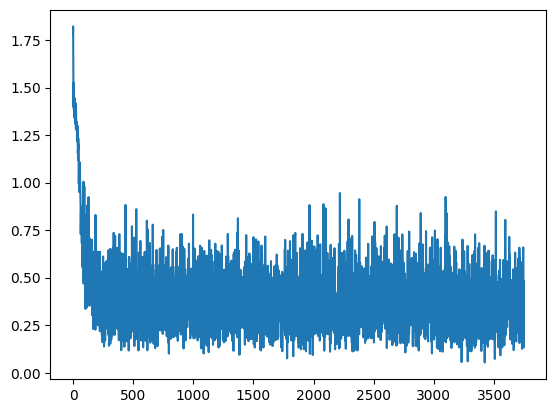

In [ ]:
from matplotlib import pyplot as plt
plt.plot(batch_losses)

Training losses over mini-batches

### 16.5.9 Evaluation

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step5.png)

We can run the very same evaluation as in the lab, except for the fact that we need to unpack the logits first.

In [ ]:
import evaluate

metric1 = evaluate.load('precision', average=None)
metric2 = evaluate.load('recall', average=None)
metric3 = evaluate.load('accuracy')

In [ ]:
model.eval()

for batch in dataloaders['test']:
    labels, sentences = batch['topic'], batch['news']
    labels = labels.to(device)

    # Step 1 - forward pass
    predictions = model(sentences)['logits']

    pred_class = predictions.argmax(dim=1).tolist()
    labels = labels.tolist()

    metric1.add_batch(references=labels, predictions=pred_class)
    metric2.add_batch(references=labels, predictions=pred_class)
    metric3.add_batch(references=labels, predictions=pred_class)

In [ ]:
metric1.compute(average=None), metric2.compute(average=None), metric3.compute()

({'precision': array([0.9329806 , 0.95064935, 0.84829545, 0.78139115])},
 {'recall': array([0.83526316, 0.96315789, 0.78578947, 0.91052632])},
 {'accuracy': 0.8736842105263158})

That's only two percentage points better than the single-layer linear model we used before! A little disappointing, isn't it? Perhaps we can improve our metrics even further if we switch to contextual embeddings, that is, embeddings produced by encoder-based models such as BERT and RoBERTa.

Nonetheless, our model is quite good and, even better, it allows us to explore what's happening inside its head(s), literally. Let's see what's in there!

### 16.5.10 Visualizing Attention

In order to visualize the attention scores (alphas), we need to feed our model a mini-batch of sentences:

In [ ]:
batch = next(iter(dataloaders['train']))
labels, sentences = batch['topic'], batch['news']

model.eval()
out = model(sentences)
scores = out['alphas']
scores.shape

torch.Size([32, 2, 48])

There are two heads, and several tokens they may pay attention to. Let's take the index corresponding to the highest score (disregarding the first score that corresponds to the classifier token we prepended to each sentence inside our model):

In [ ]:
top_idxs = scores[:, :, 1:].argmax(dim=2).tolist()
top_idxs[:3]

[[6, 1], [1, 15], [12, 0]]

Now, let's use these indices to inspect which tokens (words) were assigned the higher score by each one of the attention heads, and compare the predicted and actual labels:

In [ ]:
import pandas as pd

class_labels = ['world', 'sports', 'business', 'sci/tech']

results = [(class_labels[label], class_labels[prediction], tokens[idxs[0]], tokens[idxs[1]], description)
 for tokens, idxs, label, prediction, description in
 zip([tokenizer(s) for s in sentences], top_idxs, labels.tolist(), out['logits'].argmax(dim=1).tolist(), sentences)]

pd.DataFrame(results, columns=['Label', 'Prediction', 'Head #1', 'Head #2', 'News'])

,Label,Prediction,Head #1,Head #2,News
0,sci/tech,sci/tech,blog,com,washingtonpost.com - The idea of penning a blo...
1,business,business,reuters,pondered,LONDON (Reuters) - U.S. Treasury prices drifte...
2,sports,sports,resume,andruw,Andruw Jones has notched another Gold Glove Aw...
3,business,business,reported,shares,American Express' reported revenue was $7.2 b...
4,world,world,nuclear,experiment,The government doesn't believe Seoul intended ...
5,world,world,abuja,flights,ABUJA (Reuters) - Sudan bowed to international...
6,world,world,peace,game,Another round of India-Pakistan peace talks ov...
7,sports,sports,fallon,fergal,LONDON - Champion jockey Kieron Fallon and col...
8,world,world,ap,lecturing,AP - Tom Daschle says he might consider writin...
9,sci/tech,sci/tech,inc,paypal,NEW YORK -- Apple Computer Inc.'s online music...


Take some time to go over the examples above, and notice the similarities among the words chosen by the heads to classify sentences into a given topic, say, sports.

You'll see that the heads often choose team names or sports celebrities as the most important token for classifying a sentence. The same holds true for country names, which usually drive a classification into the "world" class.

## 16.6 Contextual Embeddings

####Contextual Embeddings: Overview
Traditional word embeddings such as GloVe do not take into account the context surrounding the word, so they give you exactly the same embeddings even if the word has a completely different meaning. For example, take the word "bank" in the following sentences:

"I am going to the bank to make a deposit"
"I am walking by the river bank"
Same word, totally different meaning. Contextual embeddings tackle this by taking the whole sentence as input, and producing an embedding for each word. We've seen it already, these embeddings are the hidden states returned by a Transformer Encoder.

Let's go over another example, step-by-step:

In [ ]:
sentences = ("The core of the planet is becoming unstable.",
             "The shift in the company's core business markets had impacted their quartely results.")

The word "core" has two different meanings in the sentences above. What happens if we use our model to classify them?

In [ ]:
model.eval()
out = model(sentences)
out['logits'].argmax(dim=1).tolist()

[3, 2]

The first sentence was classified as "sci/tech" and the second, as "business". We made up those sentences, so there are no true labels for them, but the classification seems alright.

Now, let's get the corresponding token index for the word "core" in each sentence, taking care of accounting for the prepended classifier token:

In [ ]:
idx0 = tokenizer(sentences[0]).index('core') + 1  # because [CLS] is 0th index
idx1 = tokenizer(sentences[1]).index('core') + 1  # because [CLS] is 0th index
idx0, idx1

(2, 6)

The output of our model is a dictionary containing both word embeddings (from GloVe) and hidden states (returned by the encoder). As expected, GloVe embeddings for "core" are exactly the same in both sentences:

In [ ]:
(out['embeddings'][0][idx0] == out['embeddings'][1][idx1]).all()

tensor(True, device='cuda:0')

The hidden states corresponding to the word "core", though, are quite different from one another - they are contextual:

In [ ]:
out['hidden_states'][0][idx0], out['hidden_states'][1][idx1]

(tensor([-0.4497, -0.2366,  1.3119,  0.0328,  1.6568,  0.4824,  0.4708, -1.9531,
         -0.2213,  0.5173,  0.8217, -0.8885, -0.5456,  0.5007, -1.4362,  0.8634,
          0.0875,  1.1094,  0.8987, -0.8079,  0.1854, -0.5527, -0.1230, -0.1543,
         -0.6870, -0.6386, -0.7477,  0.1236,  0.2323,  0.5025,  5.1051, -0.1390,
         -0.1227, -1.0278, -0.2210,  0.1615, -1.0884, -0.1216, -0.3719, -0.4975,
         -0.3412, -1.5703, -0.8033,  0.4210,  0.1574,  0.7238,  0.4053,  0.6086,
         -0.7680, -0.2086], device='cuda:0', grad_fn=<SelectBackward0>),
 tensor([-8.5940e-01,  1.7247e-01,  9.1704e-01, -7.4935e-02,  1.4693e+00,
          7.9795e-02,  5.5029e-01, -2.2418e+00, -1.8272e-01,  3.9973e-01,
          9.8661e-01, -9.4012e-01, -5.1435e-01,  6.0205e-01, -1.2629e+00,
          8.1216e-01,  3.7704e-02,  1.1156e+00,  8.7030e-01, -8.7857e-01,
          3.4521e-01, -4.9385e-01, -1.6959e-01, -1.3015e-02, -5.8358e-01,
         -7.1567e-01, -6.1075e-01,  5.5590e-02,  2.5342e-01,  5.8203e-0

Of course, we're just illustrating the general idea behind contextual word embeddings here. Encoder-based models such as BERT and RoBERTa were extensively trained in particular tasks such as "masked language modeling (MLM)" and "next sentence prediction (NSP)", to produce high-quality contextual word embeddings.

Contextual embeddings are great, but it may be unwieldy to handle sequences of embeddings, especially if the sequences are particularly long. Before, we used a bag of embeddings approach, averaging them all. But, wouldn't it be great to get "one embedding to rule them all" instead?

### 16.6.1 Sentence Embeddings

Sentence embeddings are the logical step that follows contextual embeddings. Besides, we sort of have used them already: remember the hidden state corresponding to the classifier token?

The purpose of the classifier token was to offer a "summary" of sorts of all the tokens in a sequence, thus allowing the classifier "head" to focus on a single input - the hidden state associated with the classifier token itself.

Guess what? We may use the very same hidden state as the overall sentence embedding.

In [ ]:
sentence_embeddings = out['hidden_states'][:, 0]
sentence_embeddings

tensor([[-0.2649, -0.4512, -1.2975,  0.7224, -0.0888, -0.7343, -0.3766, -0.0643,
          0.3939,  0.6378,  0.5645, -0.0503,  1.4437, -1.2197, -1.5841,  1.3188,
          0.8534, -0.9925,  0.7877,  0.0731, -1.4056,  0.6505, -0.1062, -0.7274,
         -0.1227,  2.4503, -1.8520, -0.1285, -1.4311, -0.4462,  0.8929,  1.0598,
          0.3906, -0.5520,  1.0586,  1.4380, -0.4611,  1.6221, -0.6855,  1.9875,
         -1.5243,  0.8238,  0.3206, -0.5692, -1.3963,  1.8590, -0.8841, -1.0449,
          0.8445, -0.7141],
        [-1.9259,  0.1091, -1.2457,  1.3248, -1.0880, -0.7220, -0.6054, -0.1259,
         -1.0274,  1.5982,  0.7647,  0.0962,  0.6510,  0.1553, -0.7496,  0.6452,
         -0.5879, -1.0634, -0.3218, -0.7500, -0.2992,  1.2060, -1.0453,  0.6467,
          1.0017,  1.8005, -0.6342, -1.0862, -1.6887,  0.3719, -0.2944,  1.1814,
          1.4689,  0.5045,  0.8382,  0.8718,  0.1059,  1.3380, -1.0117,  1.0391,
         -0.4653, -0.0238, -0.6908, -0.5729, -2.3675,  2.6230, -0.1142,  0.7013,


Of course, our little model isn't quite the best choice for embedding full sentences. There are much better choices out there, like sentence_transformers, a popular Python package for embedding sentences.

### 16.6.2 SentenceTransformers

[SentenceTransformers](https://www.sbert.net/) "_is a Python framework for state-of-the-art sentence, text and image embeddings_" and it can be used to compute text embeddings in more than 100 languages. It is based on PyTorch and HuggingFace Transformers and it offers a large collection of [pretrained models](https://www.sbert.net/docs/pretrained_models.html).

SentenceBERT, or sBERT for short, was the initial model developed to efficiently compute sentence embeddings. It is based on a siamese architecture, as if there were two identical BERT models side-by-side with identical (hence siamese) weights. If you want to learn more details about it, check its [documentation](https://www.sbert.net/docs/quickstart.html), and also the ["Sentence Transformers: Meanings in Disguise"](https://www.pinecone.io/learn/sentence-embeddings/) blog post.

Let's try using some sentence embeddings to perform zero-shot text classification!

### 16.6.3 Zero-Shot Text Classification Revisited

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step5.png)

Last time, we tried zero-shot text classification by computing the cosine similarity between bags of word embeddings, for sentences and labels. We found out that it performed poorly, especially for the "sports" class. Perhaps we can do better if we use sentence embeddings instead?

Let's load a pretrained SentenceTransformer model, the all-MiniLM-L6-v2, one of the most commonly used models for embedding sentences. Then, let's encode our label candidates:

In [ ]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

sentences = ['world', 'sports', 'business', 'science and technology']
labels_emb = model.encode(sentences, convert_to_tensor=True)
labels_emb.shape

/home/dvgodoy/anaconda3/envs/pyt20/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/home/dvgodoy/anaconda3/envs/pyt20/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


torch.Size([4, 384])

Four labels, four embeddings. Each embedding has 384 dimensions (as opposed to 50 from our former GloVe vectors).

Now that we have embeddings for the candidate labels, we can loop over our test set, encode the sentences in the mini-batches, and compare their embeddings using cosine similarity just like before:

In [ ]:
import evaluate

metric1 = evaluate.load('precision', average=None)
metric2 = evaluate.load('recall', average=None)
metric3 = evaluate.load('accuracy')

In [ ]:
cos = nn.CosineSimilarity(dim=-1)

for i, batch in enumerate(dataloaders['test']):
    labels, sentences = batch['topic'], batch['news']

    embeddings = model.encode(sentences, convert_to_tensor=True)

    distances = cos(embeddings.unsqueeze(1), labels_emb)

    pred_class = distances.argmax(dim=1)

    metric1.add_batch(references=labels, predictions=pred_class)
    metric2.add_batch(references=labels, predictions=pred_class)
    metric3.add_batch(references=labels, predictions=pred_class)

In [ ]:
metric1.compute(average=None), metric2.compute(average=None), metric3.compute()

({'precision': array([0.6580743 , 0.75671982, 0.55060571, 0.57694826])},
 {'recall': array([0.45684211, 0.87421053, 0.74157895, 0.46368421])},
 {'accuracy': 0.6340789473684211})

Much better than last time, right?